# 机器翻译与数据集
:label:`sec_machine_translation`

语言模型是自然语言处理的关键，
而*机器翻译*是语言模型最成功的基准测试。
因为机器翻译正是将输入序列转换成输出序列的
*序列转换模型*（sequence transduction）的核心问题。
序列转换模型在各类现代人工智能应用中发挥着至关重要的作用，
因此我们将其做为本章剩余部分和 :numref:`chap_attention`的重点。
为此，本节将介绍机器翻译问题及其后文需要使用的数据集。

*机器翻译*（machine translation）指的是
将序列从一种语言自动翻译成另一种语言。
事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，
特别是在第二次世界大战中使用计算机破解语言编码。
几十年来，在使用神经网络进行端到端学习的兴起之前，
统计学方法在这一领域一直占据主导地位
 :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`。
因为*统计机器翻译*（statistical machine translation）涉及了
翻译模型和语言模型等组成部分的统计分析，
因此基于神经网络的方法通常被称为
*神经机器翻译*（neural machine translation），
用于将两种翻译模型区分开来。

本书的关注点是神经网络机器翻译方法，强调的是端到端的学习。
与 :numref:`sec_language_model`中的语料库
是单一语言的语言模型问题存在不同，
机器翻译的数据集是由源语言和目标语言的文本序列对组成的。
因此，我们需要一种完全不同的方法来预处理机器翻译数据集，
而不是复用语言模型的预处理程序。
下面，我们看一下如何将预处理后的数据加载到小批量中用于训练。


In [124]:
import os
import torch
from d2l import torch as d2l

## [**下载和预处理数据集**]

首先，下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)
组成的“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对，
序列对由英文文本序列和翻译后的法语文本序列组成。
请注意，每个文本序列可以是一个句子，
也可以是包含多个句子的一个段落。
在这个将英语翻译成法语的机器翻译问题中，
英语是*源语言*（source language），
法语是*目标语言*（target language）。


In [125]:

d2l.DATA_URL = "https://www.manythings.org/anki/"
d2l.DATA_HUB['cmn-eng'] = ("https://www.manythings.org/anki/" + 'cmn-eng.zip',
                           '5a14afb04cc49f74e2a83f6ceb07151f3a8e59a2')
#@save
def read_data_nmt():
    """载入“英语－汉语”数据集"""
    data_dir = d2l.download_extract('cmn-eng')
    print(f'read_data_nmt: data_dir={data_dir}')
    with open(os.path.join(data_dir, 'cmn.txt'), 'r',
             encoding='utf-8') as f:
        
        return f.read()

# --- 原始文本 ---
# Hi.	嗨。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)
# Hi.	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)
# ...
def preprocess_text(text):
    processed_lines = [
        '\t'.join(line.split('\t')[:2]) 
        for line in text.splitlines()
    ]
    # 将处理好的行列表重新组合成一个字符串
    return '\n'.join(processed_lines)

raw_text = preprocess_text(read_data_nmt())

fname=../data/cmn-eng.zip, base_dir=../data, data_dir=../data/cmn-eng, ext=.zip
read_data_nmt: data_dir=../data/cmn-eng


下载数据集后，原始文本数据需要经过[**几个预处理步骤**]。
例如，我们用空格代替*不间断空格*（non-breaking space），
使用小写字母替换大写字母，并在单词和标点符号之间插入空格。


In [126]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?。！，？') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

hi .	嗨 。
hi .	你好 。
run .	你用跑的 。
stay .	待著 。
stay .	且慢 。
stop !	住手 ！
wait !	等等 ！



## [**词元化**]

与 :numref:`sec_language_model`中的字符级词元化不同，
在机器翻译中，我们更喜欢单词级词元化
（最先进的模型可能使用更高级的词元化技术）。
下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行词元，
其中每个词元要么是一个词，要么是一个标点符号。
此函数返回两个词元列表：`source`和`target`：
`source[i]`是源语言（这里是英语）第$i$个文本序列的词元列表，
`target[i]`是目标语言（这里是法语，ajee： 改成汉语了，哈哈）第$i$个文本序列的词元列表。


In [127]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['hi', '.'],
  ['hi', '.'],
  ['run', '.'],
  ['stay', '.'],
  ['stay', '.'],
  ['stop', '!']],
 [['嗨', '。'],
  ['你好', '。'],
  ['你用跑的', '。'],
  ['待著', '。'],
  ['且慢', '。'],
  ['住手', '！']])

让我们[**绘制每个文本序列所包含的词元数量的直方图**]。
在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于$20$个。


In [128]:
# --- 这是新的、带标注功能的函数 ---
def show_hist_with_annotations(legend, xlabel, ylabel, xlist, ylist, bins=10):
    """绘制列表长度对的直方图，并在柱子顶部标注区间范围。"""
    d2l.set_figsize()
    
    # 1. 绘制直方图并获取返回信息
    # counts: 每个箱子里的样本数
    # bin_edges: 箱子的边界
    # patches: 每个柱子的图形对象
    counts, bin_edges, patches = d2l.plt.hist(
        [[len(m) for m in xlist], [len(m) for m in ylist]], 
        bins=bins
    )
    
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    
    # 给 target 的柱子添加斜线样式
    for patch in patches[1].patches:
        patch.set_hatch('/')
    
    d2l.plt.legend(legend)
    
    # 2. 遍历每个柱子 (patch) 并添加文本标注
    # patches 是一个包含两个列表的列表，分别对应 source 和 target
    for i, patch_list in enumerate(patches):
        for patch in patch_list:
            # 获取柱子的高度、x坐标和宽度
            height = patch.get_height()
            
            # 如果柱子高度为0，则不进行标注
            if height > 0:
                x = patch.get_x()
                width = patch.get_width()
                
                # 创建标签文本，格式为 "起始-结束"
                label_text = f'{x:.0f}-{x + width:.0f}'
                
                # 计算文本的x, y坐标
                x_pos = x + width / 2
                y_pos = height + (d2l.plt.ylim()[1] * 0.01) # 在柱顶上方留一点空隙
                
                # 添加文本
                d2l.plt.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=9)


Source (源) 中出现过的长度种类 (26 种): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 29, 30, 34]
Target (目标) 中出现过的长度种类 (6 种): [1, 2, 3, 4, 5, 6]


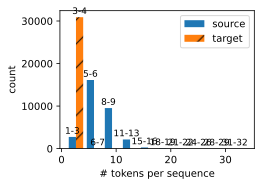

In [129]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(lx) for lx in xlist], [len(lx) for lx in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

source_lengths = [len(ll) for ll in source]
target_lengths = [len(ll) for ll in target]
unique_source_lengths = sorted(list(set(source_lengths)))
unique_target_lengths = sorted(list(set(target_lengths)))
print(f"Source (源) 中出现过的长度种类 ({len(unique_source_lengths)} 种): {unique_source_lengths}")
print(f"Target (目标) 中出现过的长度种类 ({len(unique_target_lengths)} 种): {unique_target_lengths}")


show_hist_with_annotations(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

## [**词表**]

由于机器翻译数据集由语言对组成，
因此我们可以分别为源语言和目标语言构建两个词表。
使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。
为了缓解这一问题，这里我们将出现次数少于2次的低频率词元
视为相同的未知（“&lt;unk&gt;”）词元。
除此之外，我们还指定了额外的特定词元，
例如在小批量时用于将序列填充到相同长度的填充词元（“&lt;pad&gt;”），
以及序列的开始词元（“&lt;bos&gt;”）和结束词元（“&lt;eos&gt;”）。
这些特殊词元在自然语言处理任务中比较常用。


In [130]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])

# Check if the attribute exists to be safe
if hasattr(src_vocab, 'token_to_idx'):
    # Get the dictionary of token-to-index mappings
    vocab_dict = src_vocab.token_to_idx
    
    # The vocabulary can be very large, so let's just print the first 15 items
    print("--- First 15 items in the vocabulary (token -> index) ---")
    # We convert the dictionary items to a list to slice them
    for token, index in list(vocab_dict.items())[:15]:
        print(f"'{token}': {index}")

    print(f"\nTotal vocabulary size reported by len(): {len(src_vocab)}")
else:
    print("Could not find the 'token_to_idx' attribute. The attribute might be named differently, like 'stoi'.")

len(src_vocab)

--- First 15 items in the vocabulary (token -> index) ---
'<unk>': 0
'<pad>': 1
'<bos>': 2
'<eos>': 3
'.': 4
'the': 5
'i': 6
'to': 7
'you': 8
'?': 9
'a': 10
'is': 11
'tom': 12
'he': 13
'in': 14

Total vocabulary size reported by len(): 4694


4694

## 加载数据集
:label:`subsec_mt_data_loading`

回想一下，语言模型中的[**序列样本都有一个固定的长度**]，
无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。
这个固定长度是由 :numref:`sec_language_model`中的
`num_steps`（时间步数或词元数量）参数指定的。
在机器翻译中，每个样本都是由源和目标组成的文本序列对，
其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过*截断*（truncation）和
*填充*（padding）方式实现一次只处理一个小批量的文本序列。
假设同一个小批量中的每个序列都应该具有相同的长度`num_steps`，
那么如果文本序列的词元数目少于`num_steps`时，
我们将继续在其末尾添加特定的“&lt;pad&gt;”词元，
直到其长度达到`num_steps`；
反之，我们将截断文本序列时，只取其前`num_steps` 个词元，
并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度，
以便以相同形状的小批量进行加载。

如前所述，下面的`truncate_pad`函数将(**截断或填充文本序列**)。


In [131]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[1485, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列
[**转换成小批量数据集用于训练**]。
我们将特定的“&lt;eos&gt;”词元添加到所有序列的末尾，
用于表示序列的结束。
当模型通过一个词元接一个词元地生成序列进行预测时，
生成的“&lt;eos&gt;”词元说明完成了序列输出工作。
此外，我们还记录了每个文本序列的长度，
统计长度时排除了填充词元，
在稍后将要介绍的一些模型会需要这个长度信息。


In [132]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines] # ajee: d2l.Vocab 对象被设计为可以接收一整个列表的词元。当你把列表 l（例如 ['hello', 'world']）传给它时，它会一次性地处理这个列表中的所有词元，并返回一个包含所有对应索引的新列表（例如 [3, 4]）。
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    print(f"build_array_nmt: array.shape={array.shape}, dtype={array.dtype}")
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## [**训练模型**]

最后，我们定义`load_data_nmt`函数来返回数据迭代器，
以及源语言和目标语言的两种词表。


In [133]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(preprocess_text(read_data_nmt()))
    print(f"load_data_nmt: text length={len(text)}, text[:100] = {text[:100]}")
    source, target = tokenize_nmt(text, num_examples)
    print(f"source[:6] = {source[:6]}")
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    print(f"src_vocab size: {len(src_vocab)}, tgt_vocab size: {len(tgt_vocab)}")
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

下面我们[**读出“英语－法语”数据集中的第一个小批量数据**]。


In [134]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32), "X shape:", X.shape)
    print('X的有效长度:', X_valid_len, "X_valid_len shape", X_valid_len.shape, "X shape:", X.shape)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len,"Y_valid_len shape", Y_valid_len.shape, "Y shape:", Y.shape)
    break

fname=../data/cmn-eng.zip, base_dir=../data, data_dir=../data/cmn-eng, ext=.zip
read_data_nmt: data_dir=../data/cmn-eng
load_data_nmt: text length=1375412, text[:100] = hi .	嗨 。
hi .	你好 。
run .	你用跑的 。
stay .	待著 。
stay .	且慢 。
stop !	住手 ！
wait !	等等 ！
wait !	等一下 ！
begin .
source[:6] = [['hi', '.'], ['hi', '.'], ['run', '.'], ['stay', '.'], ['stay', '.'], ['stop', '!']]
src_vocab size: 218, tgt_vocab size: 87
build_array_nmt: array.shape=torch.Size([601, 8]), dtype=torch.int64
build_array_nmt: array.shape=torch.Size([601, 8]), dtype=torch.int64
X: tensor([[ 7,  0,  4,  3,  1,  1,  1,  1],
        [20,  0,  4,  3,  1,  1,  1,  1]], dtype=torch.int32) X shape: torch.Size([2, 8])
X的有效长度: tensor([4, 4]) X_valid_len shape torch.Size([2]) X shape: torch.Size([2, 8])
Y: tensor([[0, 4, 3, 1, 1, 1, 1, 1],
        [0, 4, 3, 1, 1, 1, 1, 1]], dtype=torch.int32)
Y的有效长度: tensor([3, 3]) Y_valid_len shape torch.Size([2]) Y shape: torch.Size([2, 8])


## 小结

* 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。
* 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。

## 练习

1. 在`load_data_nmt`函数中尝试不同的`num_examples`参数值。这对源语言和目标语言的词表大小有何影响？
1. 某些语言（例如中文和日语）的文本没有单词边界指示符（例如空格）。对于这种情况，单词级词元化仍然是个好主意吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2776)
